In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns

#import json

#from MediaContributions import MediaContributionCalculator, ModelSpec
#from HillsTransformation import HillsTransformation
import Utils

from jax import random
import jax.numpy as jnp

import arviz as az

import numpyro
import numpyro.distributions as dist

from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive

from scipy.special import expit

from BayesRegression import BernoulliRegression

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Data file

In [86]:
model_data = pd.read_csv('17217_data.csv')
model_data = model_data.fillna(0) 
model_data.head()
model_data.shape

model_data.columns
#camps = ['tv_fr', 'onl_fr', 'bloger']
#model_data[camps]

model_data[['Noodle_frequent_buyers', 'Noodle_Eaters']] = model_data[['Noodle_frequent_buyers', 'Noodle_Eaters']] - 1

<Axes: xlabel='tv_fr', ylabel='Count'>

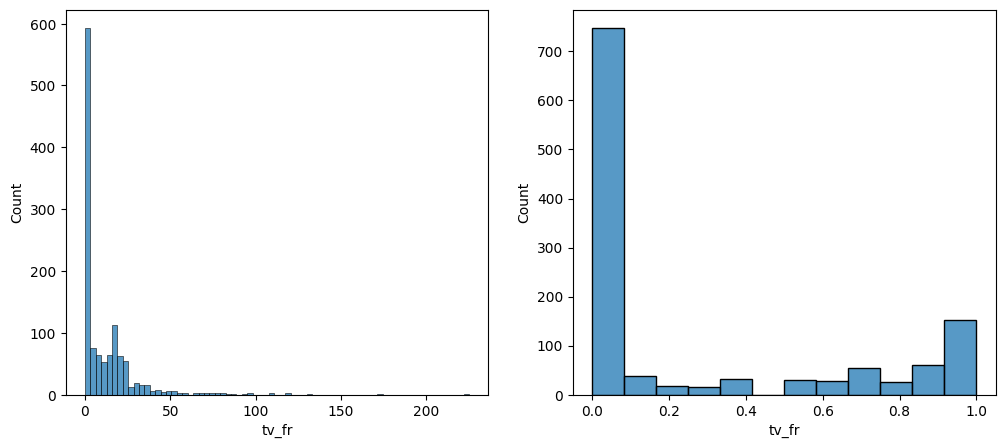

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12,  5))
sns.histplot(model_data['tv_fr'], ax=ax[0])
sns.histplot(HillsTransformation(model_data['tv_fr'], 16, 6), ax=ax[1])

<Axes: xlabel='onl_fr', ylabel='Count'>

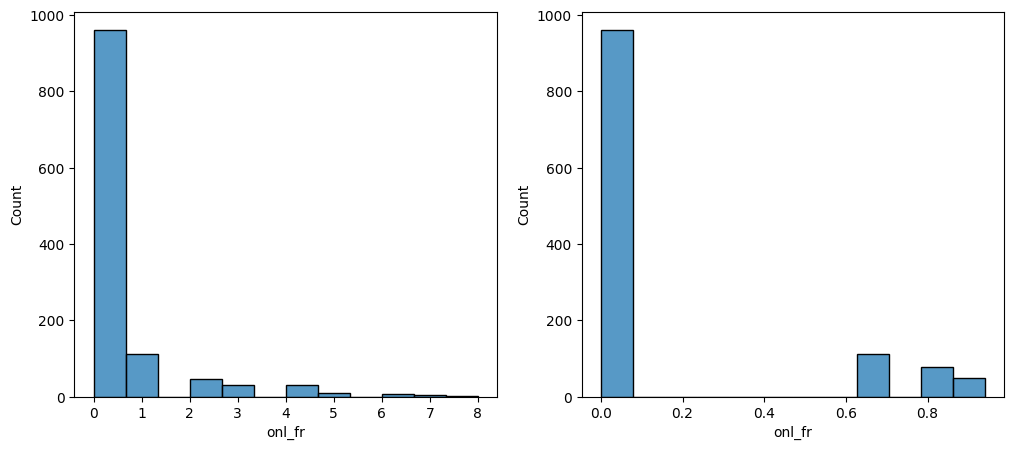

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12,  5))
sns.histplot(model_data['onl_fr'], ax=ax[0])
sns.histplot(HillsTransformation(model_data['onl_fr'], 0.5, 1), ax=ax[1])

<Axes: xlabel='bloger', ylabel='Count'>

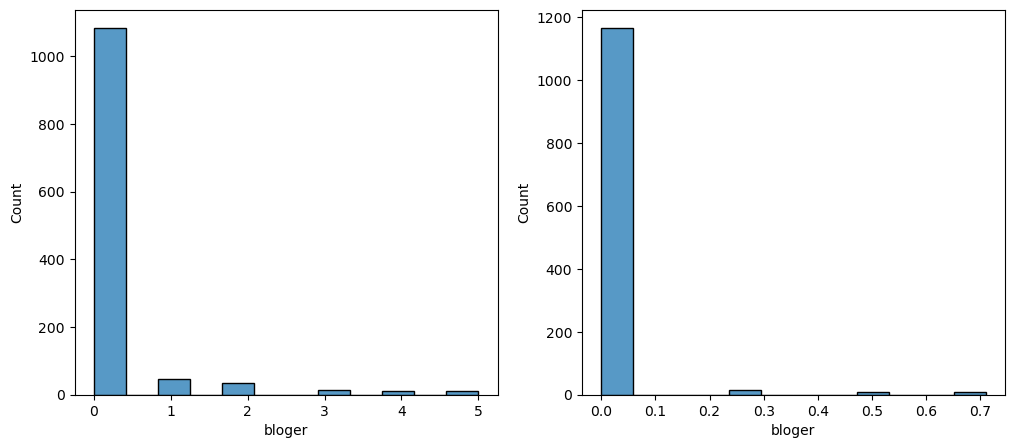

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12,  5))
sns.histplot(model_data['bloger'], ax=ax[0])
sns.histplot(HillsTransformation(model_data['bloger'], 4, 4), ax=ax[1])

# Numpyro sampling

<Axes: ylabel='Count'>

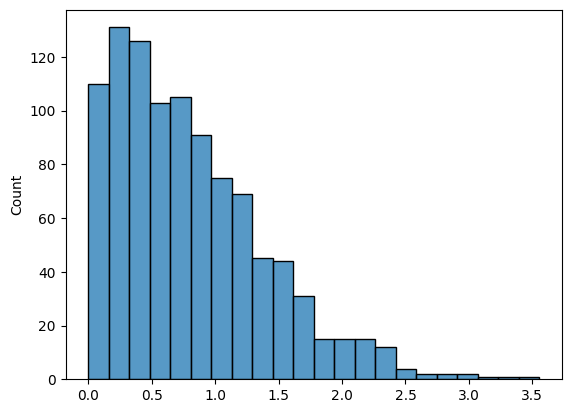

In [13]:
d = dist.HalfNormal(1).expand([1000])
s = d.sample(random.PRNGKey(1))

_, ax = plt.subplots(1, 1)
sns.histplot(s)
#ax.set_xlim(0, 1)

# Building model 

In [20]:
y = model_data['COMAW_01'].values
#X = model_data[camps].values
X = model_data['tv_fr'].values

#sns.histplot(X)

In [6]:
def Model(covs, y=None):
    if len(covs.shape) == 1: 
        covs = covs[:, jnp.newaxis]
    covs_dim = covs.shape[-1]

    intercept =   numpyro.sample("intercept", dist.Normal(0, 5))
    alpha = 20 * numpyro.sample("alpha", dist.Beta(1, 2).expand([covs_dim]).to_event(1))
    #alpha = jnp.array([16.0, 1.0, 4.0])
    gamma = 10 * numpyro.sample("gamma", dist.Beta(1, 2).expand([covs_dim]).to_event(1))
    #gamma = jnp.array([6.0, 1.0, 4.0])
    camp_beta = numpyro.sample("camp_beta", dist.Normal(0, 1).expand([covs_dim]).to_event(1))
    
    # hills transformation
    covs_pow_gamma = jnp.power(covs, gamma)
    covs_saturated = covs_pow_gamma / (covs_pow_gamma + jnp.power(alpha, gamma))
    log_prob = numpyro.deterministic("prob", intercept + (camp_beta * covs_saturated).sum(axis=1))

    numpyro.sample("obs", dist.BinomialLogits(log_prob), obs=y)

In [21]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(Model) #, init_strategy=numpyro.infer.init_to_value(values={'gamma': jnp.array([6.0, 1.0, 4.0])}))
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(
    rng_key_, covs=X, y=y
)

sample: 100%|██████████████████████████| 3000/3000 [00:05<00:00, 591.63it/s, 15 steps of size 1.59e-01. acc. prob=0.96]


In [7]:
mcmc.get_samples().keys()

dict_keys(['alpha', 'camp_beta', 'gamma', 'intercept', 'prob'])

(0.0, 10.0)

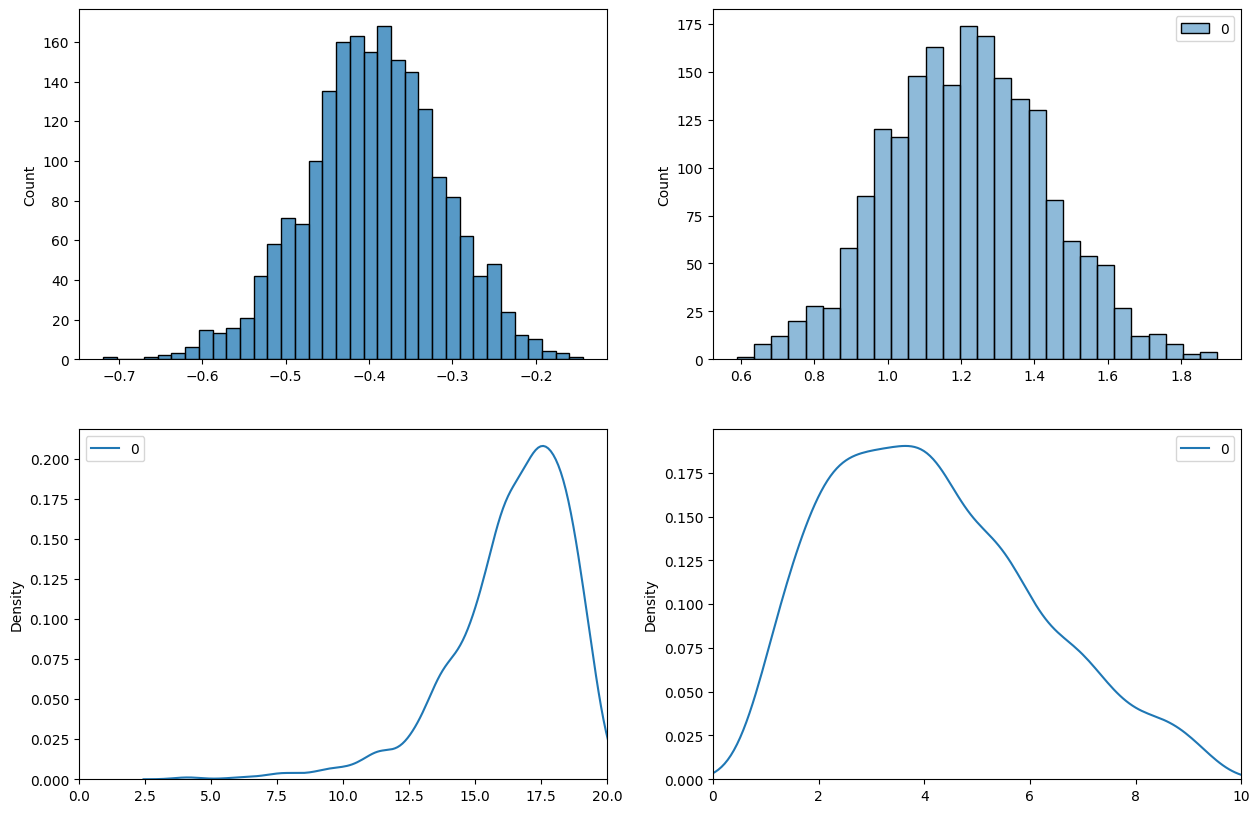

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))

sns.histplot(mcmc.get_samples()['intercept'], ax=axs[0,0])
sns.histplot(mcmc.get_samples()['camp_beta'], ax=axs[0,1])
sns.kdeplot(20 * mcmc.get_samples()['alpha'], ax=axs[1,0])
sns.kdeplot(10 * mcmc.get_samples()['gamma'], ax=axs[1,1])

axs[1,0].set_xlim(0,20)
axs[1,1].set_xlim(0,10)

In [26]:
numpyro.diagnostics.hpdi(20 * mcmc.get_samples()['alpha'], prob=.05)

array([[17.340136 ,  2.3023415,  2.8068433],
       [17.564247 ,  2.5658371,  2.9886746]], dtype=float32)

In [27]:
numpyro.diagnostics.hpdi(10 * mcmc.get_samples()['gamma'], prob=.1)

array([[2.6225781 , 0.6060261 , 0.5057014 ],
       [3.1040554 , 0.89620954, 0.8643773 ]], dtype=float32)

In [375]:
numpyro.diagnostics.hpdi(mcmc.get_samples()['camp_beta'], prob=.2)

array([[-0.05269696,  0.09986753,  0.18345053],
       [ 0.02791461,  0.3852466 ,  0.48403734]], dtype=float32)

<Axes: >

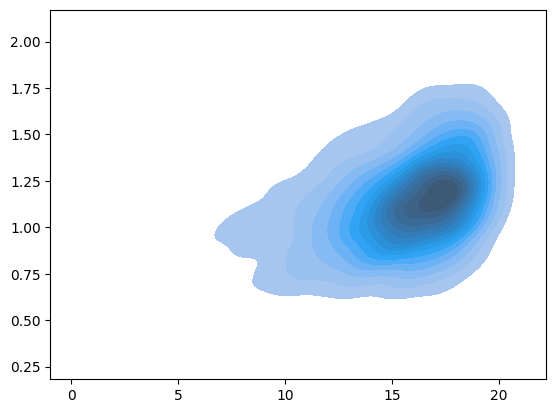

In [28]:
c = 0

x = 20 * mcmc.get_samples()['alpha'][:, c]
#y = 10 * mcmc.get_samples()['gamma'][:, c]
yy =  1 * mcmc.get_samples()['camp_beta'][:, c]

sns.kdeplot(x=x, y=yy, fill=True, levels=15)

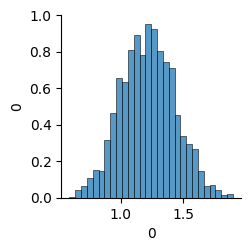

In [23]:
sns.pairplot(pd.DataFrame(mcmc.get_samples()['camp_beta']))

# Prediction

In [9]:
posterior = mcmc.get_samples()
del posterior['prob']
posterior

{'alpha': Array([[0.91129214, 0.01861268, 0.66405505],
        [0.90941364, 0.02644758, 0.6237778 ],
        [0.88763857, 0.02687112, 0.72507787],
        ...,
        [0.59826076, 0.04216036, 0.15489237],
        [0.8211478 , 0.27358562, 0.65596616],
        [0.87134784, 0.2747548 , 0.01571219]], dtype=float32),
 'camp_beta': Array([[ 1.0976452 ,  0.35769135, -0.45703775],
        [ 1.071483  ,  0.5710029 , -0.38202357],
        [ 0.93986994,  0.37309358, -0.8876411 ],
        ...,
        [ 1.0315081 ,  0.84461284, -0.38994384],
        [ 1.4483099 ,  1.2470517 ,  2.356798  ],
        [ 1.1991309 ,  0.8401568 ,  0.320821  ]], dtype=float32),
 'gamma': Array([[0.8361088 , 0.58424056, 0.2531718 ],
        [0.81446326, 0.5991229 , 0.24355628],
        [0.7259917 , 0.5509192 , 0.32168436],
        ...,
        [0.18648036, 0.05137246, 0.5828822 ],
        [0.0903494 , 0.17552006, 0.02333475],
        [0.43642932, 0.03226817, 0.6367542 ]], dtype=float32),
 'intercept': Array([-0.38858545,

In [15]:
pred_function = Predictive(Model, posterior_samples=posterior)

Average probabity; 0.47803041338920593
Average probabity; 0.47757863998413086


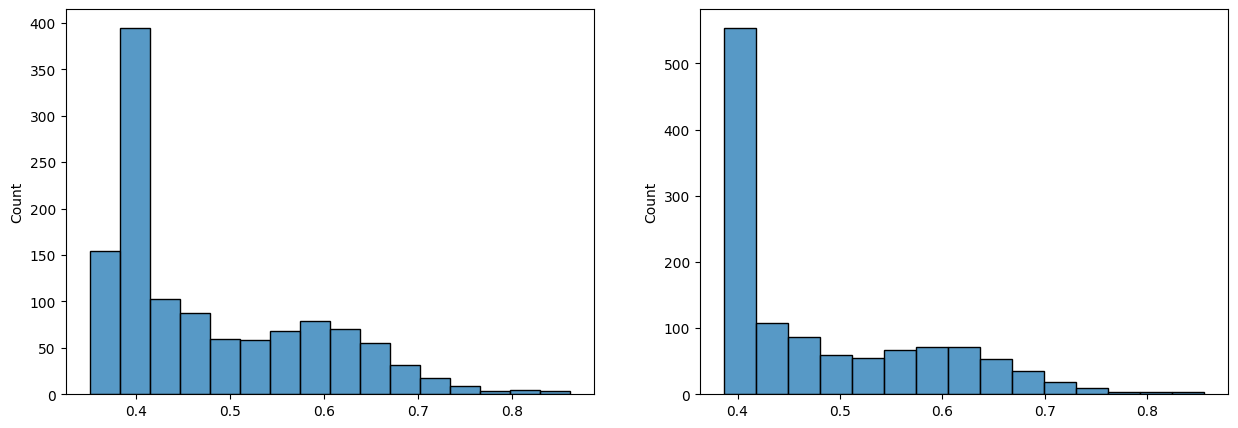

In [18]:
prediction = pred_function(rng_key, covs=X)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(prediction['obs'].mean(axis=0), ax=axs[0])
sns.histplot(expit(prediction['prob']).mean(axis=0), ax=axs[1])

print("Average probabity; {}".format(prediction['obs'].mean(axis=0).mean()))
print("Average probabity; {}".format(expit(prediction['prob']).mean(axis=0).mean()))

Average probabity; 0.3869079649448395
Average probabity; 0.3865579664707184


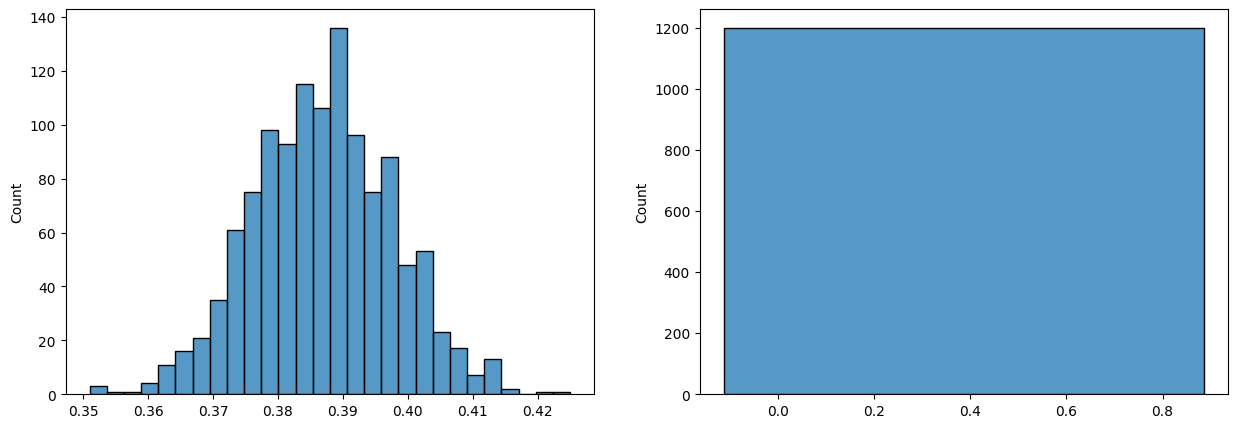

In [19]:
X_mod = X.copy()
X_mod[:, 0] = 0
X_mod[:, 1] = 0
X_mod[:, 2] = 0

prediction = pred_function(rng_key, covs=X_mod)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(prediction['obs'].mean(axis=0), ax=axs[0])
sns.histplot(expit(prediction['prob']).mean(axis=0), ax=axs[1])

print("Average probabity; {}".format(prediction['obs'].mean(axis=0).mean()))
print("Average probabity; {}".format(expit(prediction['prob']).mean(axis=0).mean()))

# validate non camps

In [24]:
fitted_model = az.from_numpyro(mcmc)

In [25]:
az.waic(fitted_model)

Computed from 2000 posterior samples and 1200 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -806.97     6.98
p_waic        3.34        -

In [30]:
model_data.columns

Index(['Respondent_Serial', 'SM_GPID', 'Pre_Post', 'yyyymmdd', 'WEEK', 'SEX',
       'AGEBANDS', 'Region', 'Region2', 'SEG', 'Brand_pref', 'Brand_loyal',
       'Brand_dif', 'TOM_01', 'TotalUnaided_01', 'Familiarity_01', 'Aided_01',
       'Tried_01', 'MostOften_01', 'BoughtLast_01', 'Consideration_01',
       'Consideration_TopBox_01', 'Consideration_T2B_01', 'KPIA_01', 'KPIB_01',
       'KPIC_01', 'KPID_01', 'KPIE_01', 'KPIF_01', 'KPIH_01', 'KPII_01',
       'KPIJ_01', 'COMAW_01', 'Emotional_01', 'Uniqueness_01', 'Rational_01',
       'Leadership_01', 'Premiumness_01', 'Cost_01', 'VarietyFamiliarity_01',
       'VarietyPI_01', 'VarietyPerception_01', 'MC1', 'MC2', 'MC2P', 'MC2B',
       'MC2N', 'WOM1', 'WOM2', 'WOM2P', 'WOM2B', 'WOM2N', 'EX1', 'EX2', 'EX2P',
       'EX2B', 'EX2N', 'COOKIES_FREQ', 'feddistr', 'Regular_Buyers_Brand1',
       'MostOften_BBW', 'Regular_BBW', 'Trial_BBW', 'Prompted_BBW',
       'Consideration_Top1_BBW', 'BB_regular_buyers', 'Noodle_frequent_buyers',
     

In [78]:
y = model_data['COMAW_01'].values
X = model_data[['tv_fr', 'onl_fr', 'tv_onl']].values

reg1 = BayesRegression("one").Fit(media_freq=X, non_media=None, y=y)
print(az.waic(az.from_numpyro(reg1.mcmc)))

sample: 100%|██████████████████████████| 3000/3000 [00:09<00:00, 324.51it/s, 15 steps of size 1.63e-01. acc. prob=0.91]


Computed from 2000 posterior samples and 1200 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -805.72     7.38
p_waic        5.61        -


In [80]:
y = model_data['COMAW_01'].values
X = model_data[['tv_fr', 'onl_fr']].values

reg2 = BayesRegression("two").Fit(media_freq=X, non_media=None, y=y)
print(az.waic(az.from_numpyro(reg2.mcmc)))

sample: 100%|██████████████████████████| 3000/3000 [00:14<00:00, 208.53it/s, 15 steps of size 2.66e-01. acc. prob=0.87]


Computed from 2000 posterior samples and 1200 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -805.21     7.25
p_waic        5.38        -


In [82]:
y = model_data['COMAW_01'].values
X = model_data[['tv_fr']].values

reg3 = BayesRegression("three").Fit(media_freq=X, non_media=None, y=y)
print(az.waic(az.from_numpyro(reg3.mcmc)))

sample: 100%|███████████████████████████| 3000/3000 [00:03<00:00, 862.98it/s, 7 steps of size 4.01e-01. acc. prob=0.90]


Computed from 2000 posterior samples and 1200 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -807.07     6.96
p_waic        3.44        -


In [89]:
y = model_data['COMAW_01'].values
Xc = model_data[['tv_fr', 'onl_fr', 'tv_onl']].values
Xn = model_data[['WOM2P', 'EX2P']].values

reg4 = BayesRegression("four").Fit(media_freq=Xc, non_media=Xn, y=y)
print(az.waic(reg4.ToArviZ()))

sample: 100%|██████████████████████████| 3000/3000 [00:19<00:00, 156.08it/s, 15 steps of size 1.91e-01. acc. prob=0.90]


Computed from 2000 posterior samples and 1200 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -774.58    10.57
p_waic        6.89        -


In [9]:
def Compare(*args):
    models_dict = {m.name: m.ToArviZ() for m in args}
    compare_results = az.compare(models_dict, ic='waic')
    print(compare_results)
    az.plot_compare(compare_results)
    
#Compare(reg1, reg2, reg3, reg4)

# Feature Selection 

In [138]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector, RFECV

In [109]:
candidates = ['MC1', 'MC2', 'MC2P', 'MC2B', 'MC2N', 'WOM1', 'WOM2', 'WOM2P', 'WOM2B', 'WOM2N', 'EX1', 'EX2', 'EX2P', 'EX2B', 'EX2N']

y = model_data['COMAW_01']
X = model_data[candidates]

In [143]:
clf = LogisticRegression(C=0.2, penalty="l1", dual=False, solver='liblinear').fit(X, y)
model = SelectFromModel(clf, prefit=True)
model.fit(X, y)

print(len(model.get_feature_names_out()), model.get_feature_names_out())
#print(model.transform(X).shape)

7 ['MC1' 'MC2' 'WOM1' 'WOM2' 'WOM2B' 'EX2' 'EX2B']


In [137]:
clf = LogisticRegression()
model = SequentialFeatureSelector(clf, n_features_to_select=3)
model.fit(X, y)

print(len(model.get_feature_names_out()), model.get_feature_names_out())
#print(model.transform(X).shape)

3 ['MC2' 'WOM2' 'WOM2P']


In [142]:
clf = LogisticRegression()
model = RFECV(clf)
model.fit(X, y)

print(model.n_features_)

13


In [186]:
def ModelSelector(c=0.2):
    clf = LogisticRegression(C=c, penalty="l1", dual=False, solver='liblinear').fit(X, y)
    model = SelectFromModel(clf, prefit=True)
    model.fit(X, y)
    return tuple(model.get_feature_names_out())

ModelSelector(0.005)

('MC2', 'WOM2')

In [192]:
c = 0.001
features = set()
while c < 0.5:
    f = ModelSelector(c)
    if f:
        features.add(f)
    c += 0.005
    
features = list(features)

In [195]:
regs = []
for f_set in features:
    y = model_data['COMAW_01'].values
    Xc = model_data[['tv_fr', 'onl_fr', 'tv_onl']].values
    Xn = model_data[list(f_set)].values

    regs.append(BayesRegression(str(f_set)).Fit(media_freq=Xc, non_media=Xn, y=y))

sample: 100%|██████████████████████████| 3000/3000 [00:11<00:00, 266.65it/s, 15 steps of size 2.34e-01. acc. prob=0.87]


                                                    rank    elpd_loo  \
('MC1', 'MC2', 'MC2B', 'WOM1', 'WOM2', 'WOM2B',...     0 -729.164423   
('MC1', 'MC2', 'MC2B', 'WOM1', 'WOM2', 'WOM2B',...     1 -729.921427   
('MC1', 'MC2', 'WOM1', 'WOM2', 'WOM2B', 'EX2', ...     2 -730.225040   
('MC1', 'MC2', 'WOM1', 'WOM2', 'EX2', 'EX2B')          3 -731.778800   
('MC2', 'WOM1', 'WOM2', 'EX2')                         4 -731.797239   
('MC2', 'WOM2', 'EX2')                                 5 -734.814489   
('MC2', 'WOM2')                                        6 -737.628269   

                                                        p_loo  elpd_diff  \
('MC1', 'MC2', 'MC2B', 'WOM1', 'WOM2', 'WOM2B',...  12.663350   0.000000   
('MC1', 'MC2', 'MC2B', 'WOM1', 'WOM2', 'WOM2B',...  13.884233   0.757003   
('MC1', 'MC2', 'WOM1', 'WOM2', 'WOM2B', 'EX2', ...  12.068653   1.060616   
('MC1', 'MC2', 'WOM1', 'WOM2', 'EX2', 'EX2B')       11.027113   2.614376   
('MC2', 'WOM1', 'WOM2', 'EX2')             

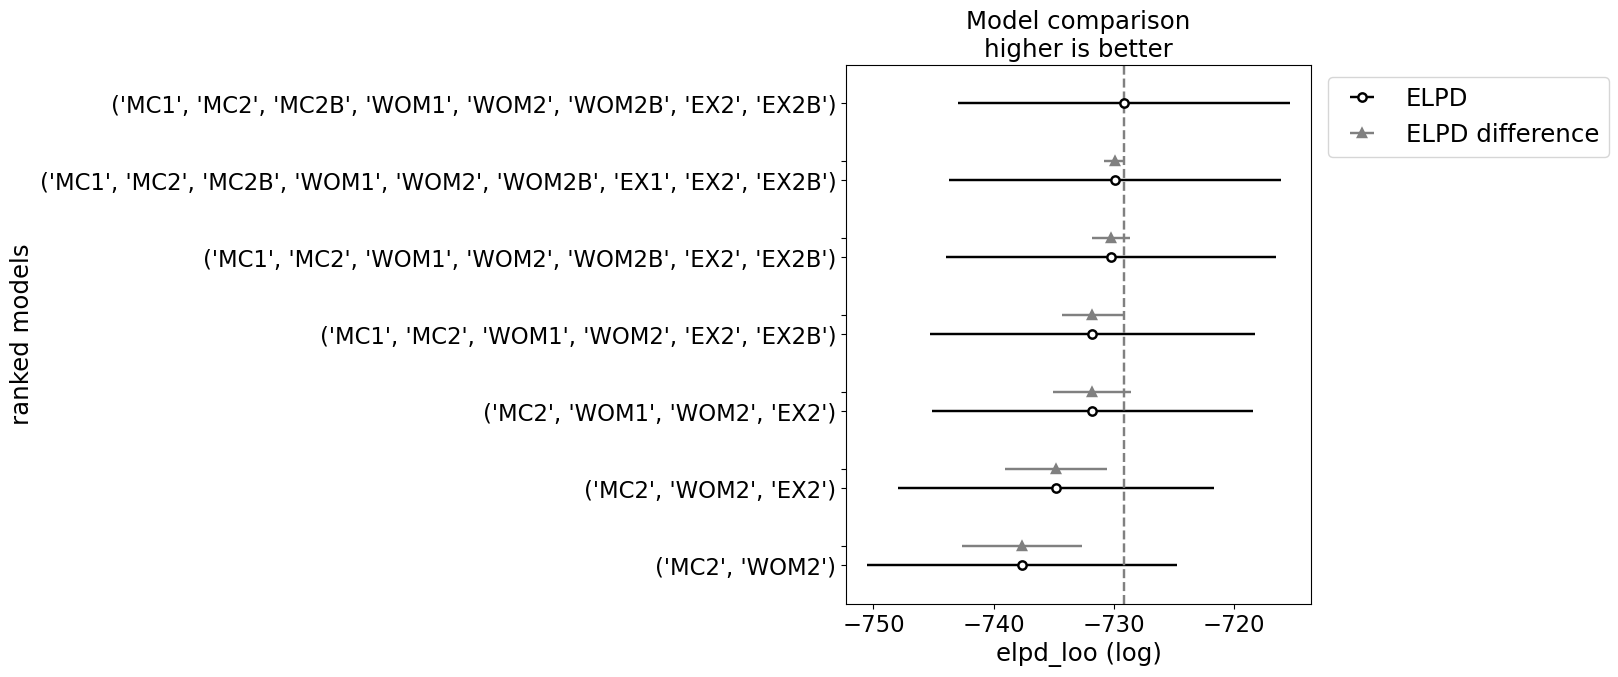

In [212]:
Compare(*regs)

In [218]:
model_data.columns

Index(['Respondent_Serial', 'SM_GPID', 'Pre_Post', 'yyyymmdd', 'WEEK', 'SEX',
       'AGEBANDS', 'Region', 'Region2', 'SEG', 'Brand_pref', 'Brand_loyal',
       'Brand_dif', 'TOM_01', 'TotalUnaided_01', 'Familiarity_01', 'Aided_01',
       'Tried_01', 'MostOften_01', 'BoughtLast_01', 'Consideration_01',
       'Consideration_TopBox_01', 'Consideration_T2B_01', 'KPIA_01', 'KPIB_01',
       'KPIC_01', 'KPID_01', 'KPIE_01', 'KPIF_01', 'KPIH_01', 'KPII_01',
       'KPIJ_01', 'COMAW_01', 'Emotional_01', 'Uniqueness_01', 'Rational_01',
       'Leadership_01', 'Premiumness_01', 'Cost_01', 'VarietyFamiliarity_01',
       'VarietyPI_01', 'VarietyPerception_01', 'MC1', 'MC2', 'MC2P', 'MC2B',
       'MC2N', 'WOM1', 'WOM2', 'WOM2P', 'WOM2B', 'WOM2N', 'EX1', 'EX2', 'EX2P',
       'EX2B', 'EX2N', 'COOKIES_FREQ', 'feddistr', 'Regular_Buyers_Brand1',
       'MostOften_BBW', 'Regular_BBW', 'Trial_BBW', 'Prompted_BBW',
       'Consideration_Top1_BBW', 'BB_regular_buyers', 'Noodle_frequent_buyers',
     

In [217]:
regs

[('MC2', 'WOM2'),
 ('MC2', 'WOM2', 'EX2'),
 ('MC1', 'MC2', 'WOM1', 'WOM2', 'WOM2B', 'EX2', 'EX2B'),
 ('MC1', 'MC2', 'MC2B', 'WOM1', 'WOM2', 'WOM2B', 'EX1', 'EX2', 'EX2B'),
 ('MC2', 'WOM1', 'WOM2', 'EX2'),
 ('MC1', 'MC2', 'WOM1', 'WOM2', 'EX2', 'EX2B'),
 ('MC1', 'MC2', 'MC2B', 'WOM1', 'WOM2', 'WOM2B', 'EX2', 'EX2B')]

array([<Axes: title={'center': 'non_media_beta\n0'}>,
       <Axes: title={'center': 'non_media_beta\n1'}>,
       <Axes: title={'center': 'non_media_beta\n2'}>,
       <Axes: title={'center': 'non_media_beta\n3'}>], dtype=object)

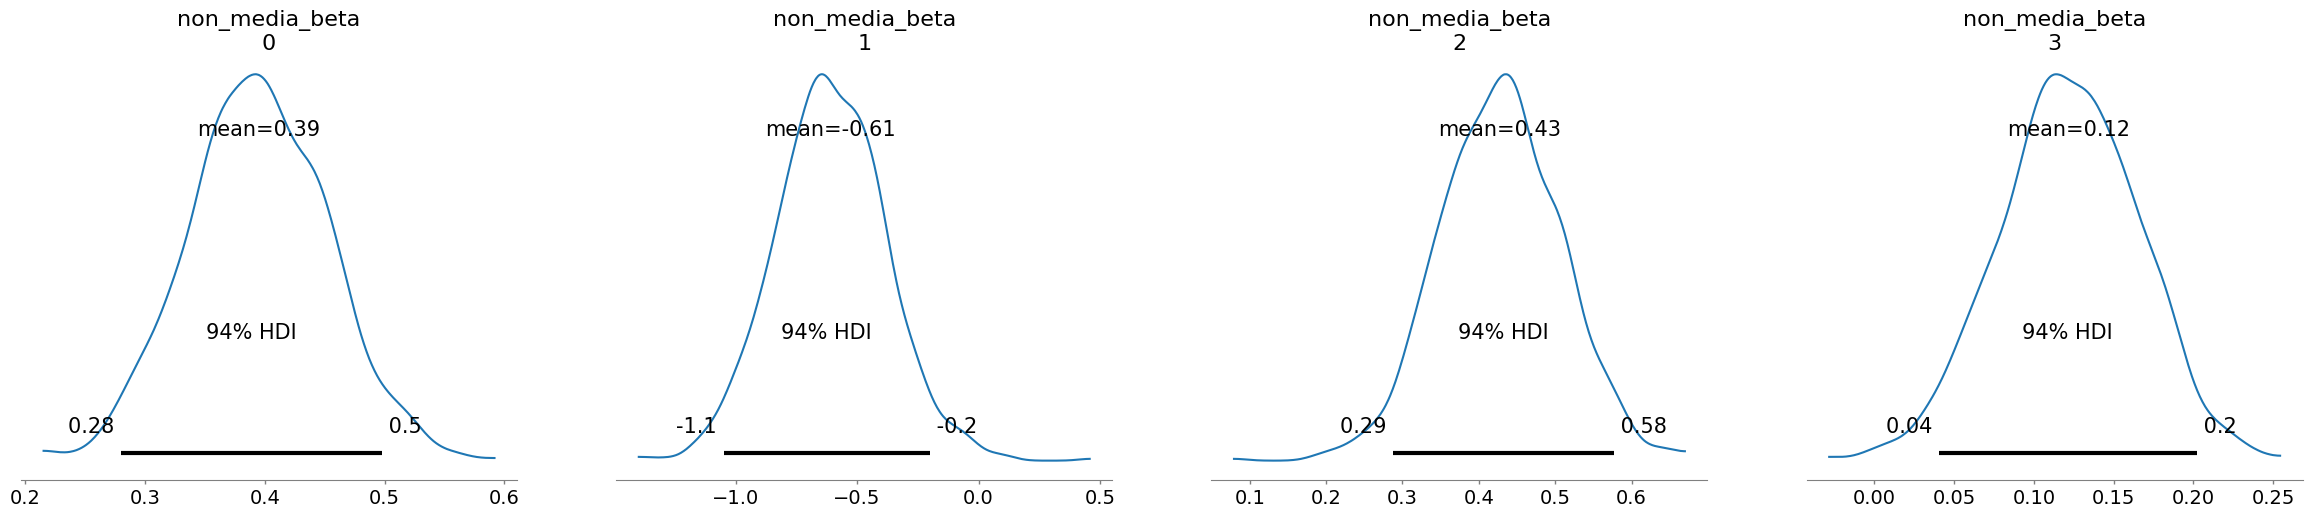

In [216]:
az.plot_posterior(regs[4].ToArviZ(), var_names=['non_media_beta'])

# validate RG

In [3]:
model_data[['Noodle_frequent_buyers', 'Noodle_Eaters']]

,Noodle_frequent_buyers,Noodle_Eaters
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
1195,1,1
1196,0,1
1197,1,1
1198,1,1


In [21]:
y = model_data['COMAW_01'].values
Xc = model_data[['tv_fr', 'onl_fr', 'tv_onl']].values
Xn = model_data[['MC2', 'WOM2', 'EX2']].values
Xr = model_data['Noodle_frequent_buyers'].values

reg = BayesRegression("no RG").Fit(media_freq=Xc, non_media=Xn, rg_var=None, y=y)
print(az.waic(reg.ToArviZ()))

NoRG


sample: 100%|██████████████████████████| 3000/3000 [00:12<00:00, 241.13it/s, 15 steps of size 1.76e-01. acc. prob=0.92]


Computed from 2000 posterior samples and 1200 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -734.94    13.16
p_waic        8.02        -


In [22]:
y = model_data['COMAW_01'].values
Xc = model_data[['tv_fr', 'onl_fr', 'tv_onl']].values
Xn = model_data[['MC2', 'WOM2', 'EX2']].values
Xr = model_data['Noodle_frequent_buyers'].values

reg1 = BayesRegression("RG: nfb").Fit(media_freq=Xc, non_media=Xn, rg_var=Xr, y=y)
print(az.waic(reg1.ToArviZ()))

with RG


sample: 100%|██████████████████████████| 3000/3000 [00:08<00:00, 350.21it/s, 15 steps of size 2.45e-01. acc. prob=0.85]


Computed from 2000 posterior samples and 1200 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -736.03    13.54
p_waic       13.75        -


         rank   elpd_waic     p_waic  elpd_diff    weight         se  \
no RG       0 -734.937278   8.019218   0.000000  0.624119  13.162624   
RG: nfb     1 -736.029841  13.752300   1.092563  0.375881  13.539604   

              dse  warning scale  
no RG    0.000000    False   log  
RG: nfb  2.944777    False   log  


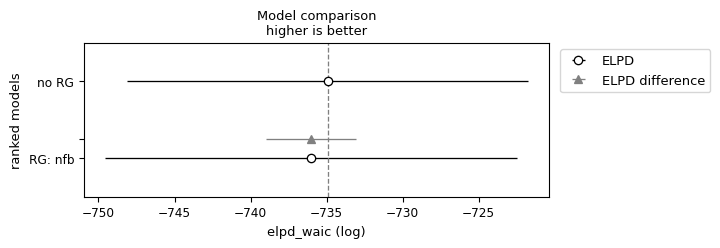

In [23]:
Compare(reg, reg1)

In [11]:
y = model_data['COMAW_01'].values
Xc = model_data[['tv_fr', 'onl_fr', 'tv_onl']].values
Xn = model_data[['MC2', 'WOM2', 'EX2']].values
Xr = model_data['Noodle_frequent_buyers'].values

reg1_1 = BayesRegression("RG: nfb hierarch").Fit(media_freq=Xc, non_media=Xn, rg_var=Xr, y=y)
print(az.waic(reg1_1.ToArviZ()))

with RG


sample: 100%|██████████████████████████| 3000/3000 [00:11<00:00, 251.01it/s, 31 steps of size 1.52e-01. acc. prob=0.90]


Computed from 2000 posterior samples and 1200 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -736.75    12.90
p_waic       10.21        -


In [6]:
y = model_data['COMAW_01'].values
Xc = model_data[['tv_fr', 'onl_fr', 'tv_onl']].values
Xn = model_data[['MC2', 'WOM2', 'EX2']].values
Xr = model_data['Noodle_Eaters'].values

reg2 = BayesRegression("ne").Fit(media_freq=Xc, non_media=Xn, rg_var=Xr, y=y)
print(az.waic(reg2.ToArviZ()))

with RG


sample: 100%|██████████████████████████| 3000/3000 [00:15<00:00, 194.13it/s, 15 steps of size 2.01e-01. acc. prob=0.88]


Computed from 2000 posterior samples and 1200 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -739.64    13.41
p_waic       14.37        -


In [12]:
y = model_data['COMAW_01'].values
Xc = model_data[['tv_fr', 'onl_fr', 'tv_onl']].values
Xn = model_data[['MC2', 'WOM2', 'EX2']].values
Xr = model_data['Noodle_Eaters'].values

reg2_1 = BayesRegression("ne: hierarc").Fit(media_freq=Xc, non_media=Xn, rg_var=Xr, y=y)
print(az.waic(reg2_1.ToArviZ()))

with RG


sample: 100%|██████████████████████████| 3000/3000 [00:11<00:00, 262.00it/s, 15 steps of size 1.54e-01. acc. prob=0.77]


Computed from 2000 posterior samples and 1200 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -739.56    12.82
p_waic        9.76        -


                  rank   elpd_waic     p_waic  elpd_diff        weight  \
no RG                0 -734.789988   7.841429   0.000000  7.275367e-01   
RG: nfb hierarch     1 -736.754514  10.213007   1.964526  2.724633e-01   
ne: hierarc          2 -739.558042   9.764848   4.768054  1.554312e-15   

                         se       dse  warning scale  
no RG             13.162420  0.000000    False   log  
RG: nfb hierarch  12.904722  2.944496    False   log  
ne: hierarc       12.817815  2.505762    False   log  


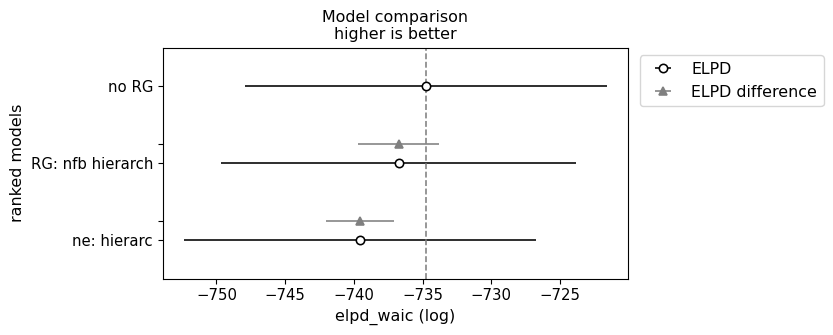

In [17]:
Compare(reg, reg1_1, reg2_1)

array([[<Axes: title={'center': 'media_beta\n0, 0'}>,
        <Axes: title={'center': 'media_beta\n0, 1'}>,
        <Axes: title={'center': 'media_beta\n0, 2'}>],
       [<Axes: title={'center': 'media_beta\n0, 3'}>,
        <Axes: title={'center': 'media_beta\n0, 4'}>,
        <Axes: title={'center': 'media_beta\n0, 5'}>],
       [<Axes: title={'center': 'media_beta\n1, 0'}>,
        <Axes: title={'center': 'media_beta\n1, 1'}>,
        <Axes: title={'center': 'media_beta\n1, 2'}>],
       [<Axes: title={'center': 'media_beta\n1, 3'}>,
        <Axes: title={'center': 'media_beta\n1, 4'}>,
        <Axes: title={'center': 'media_beta\n1, 5'}>]], dtype=object)

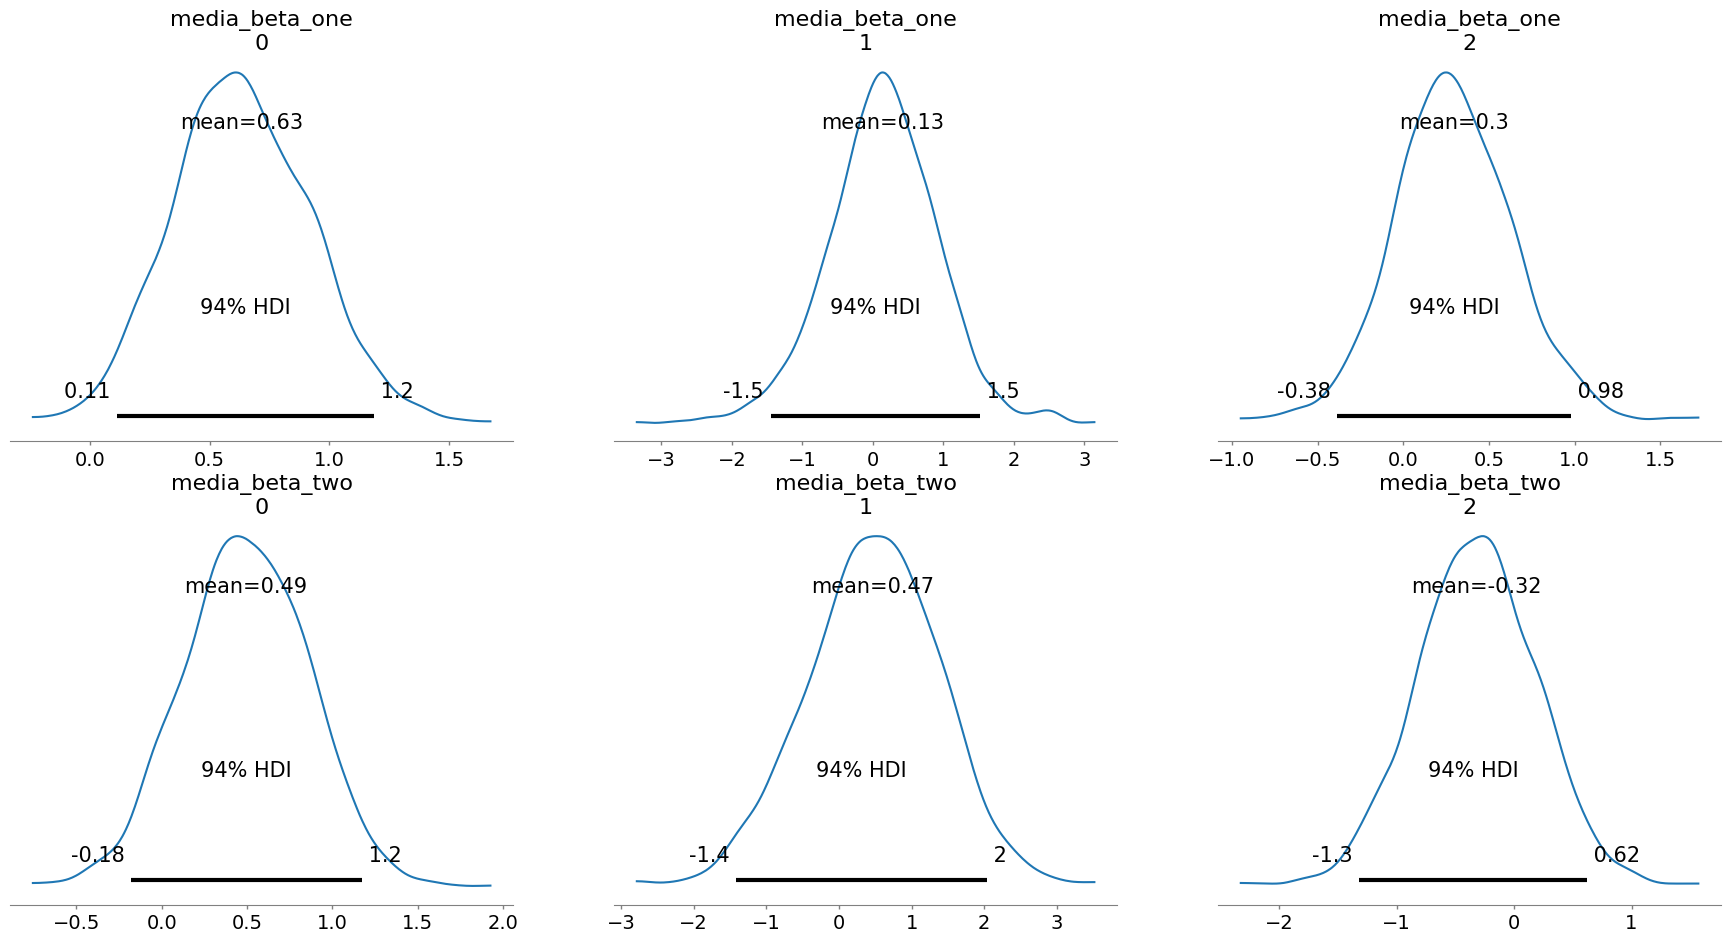

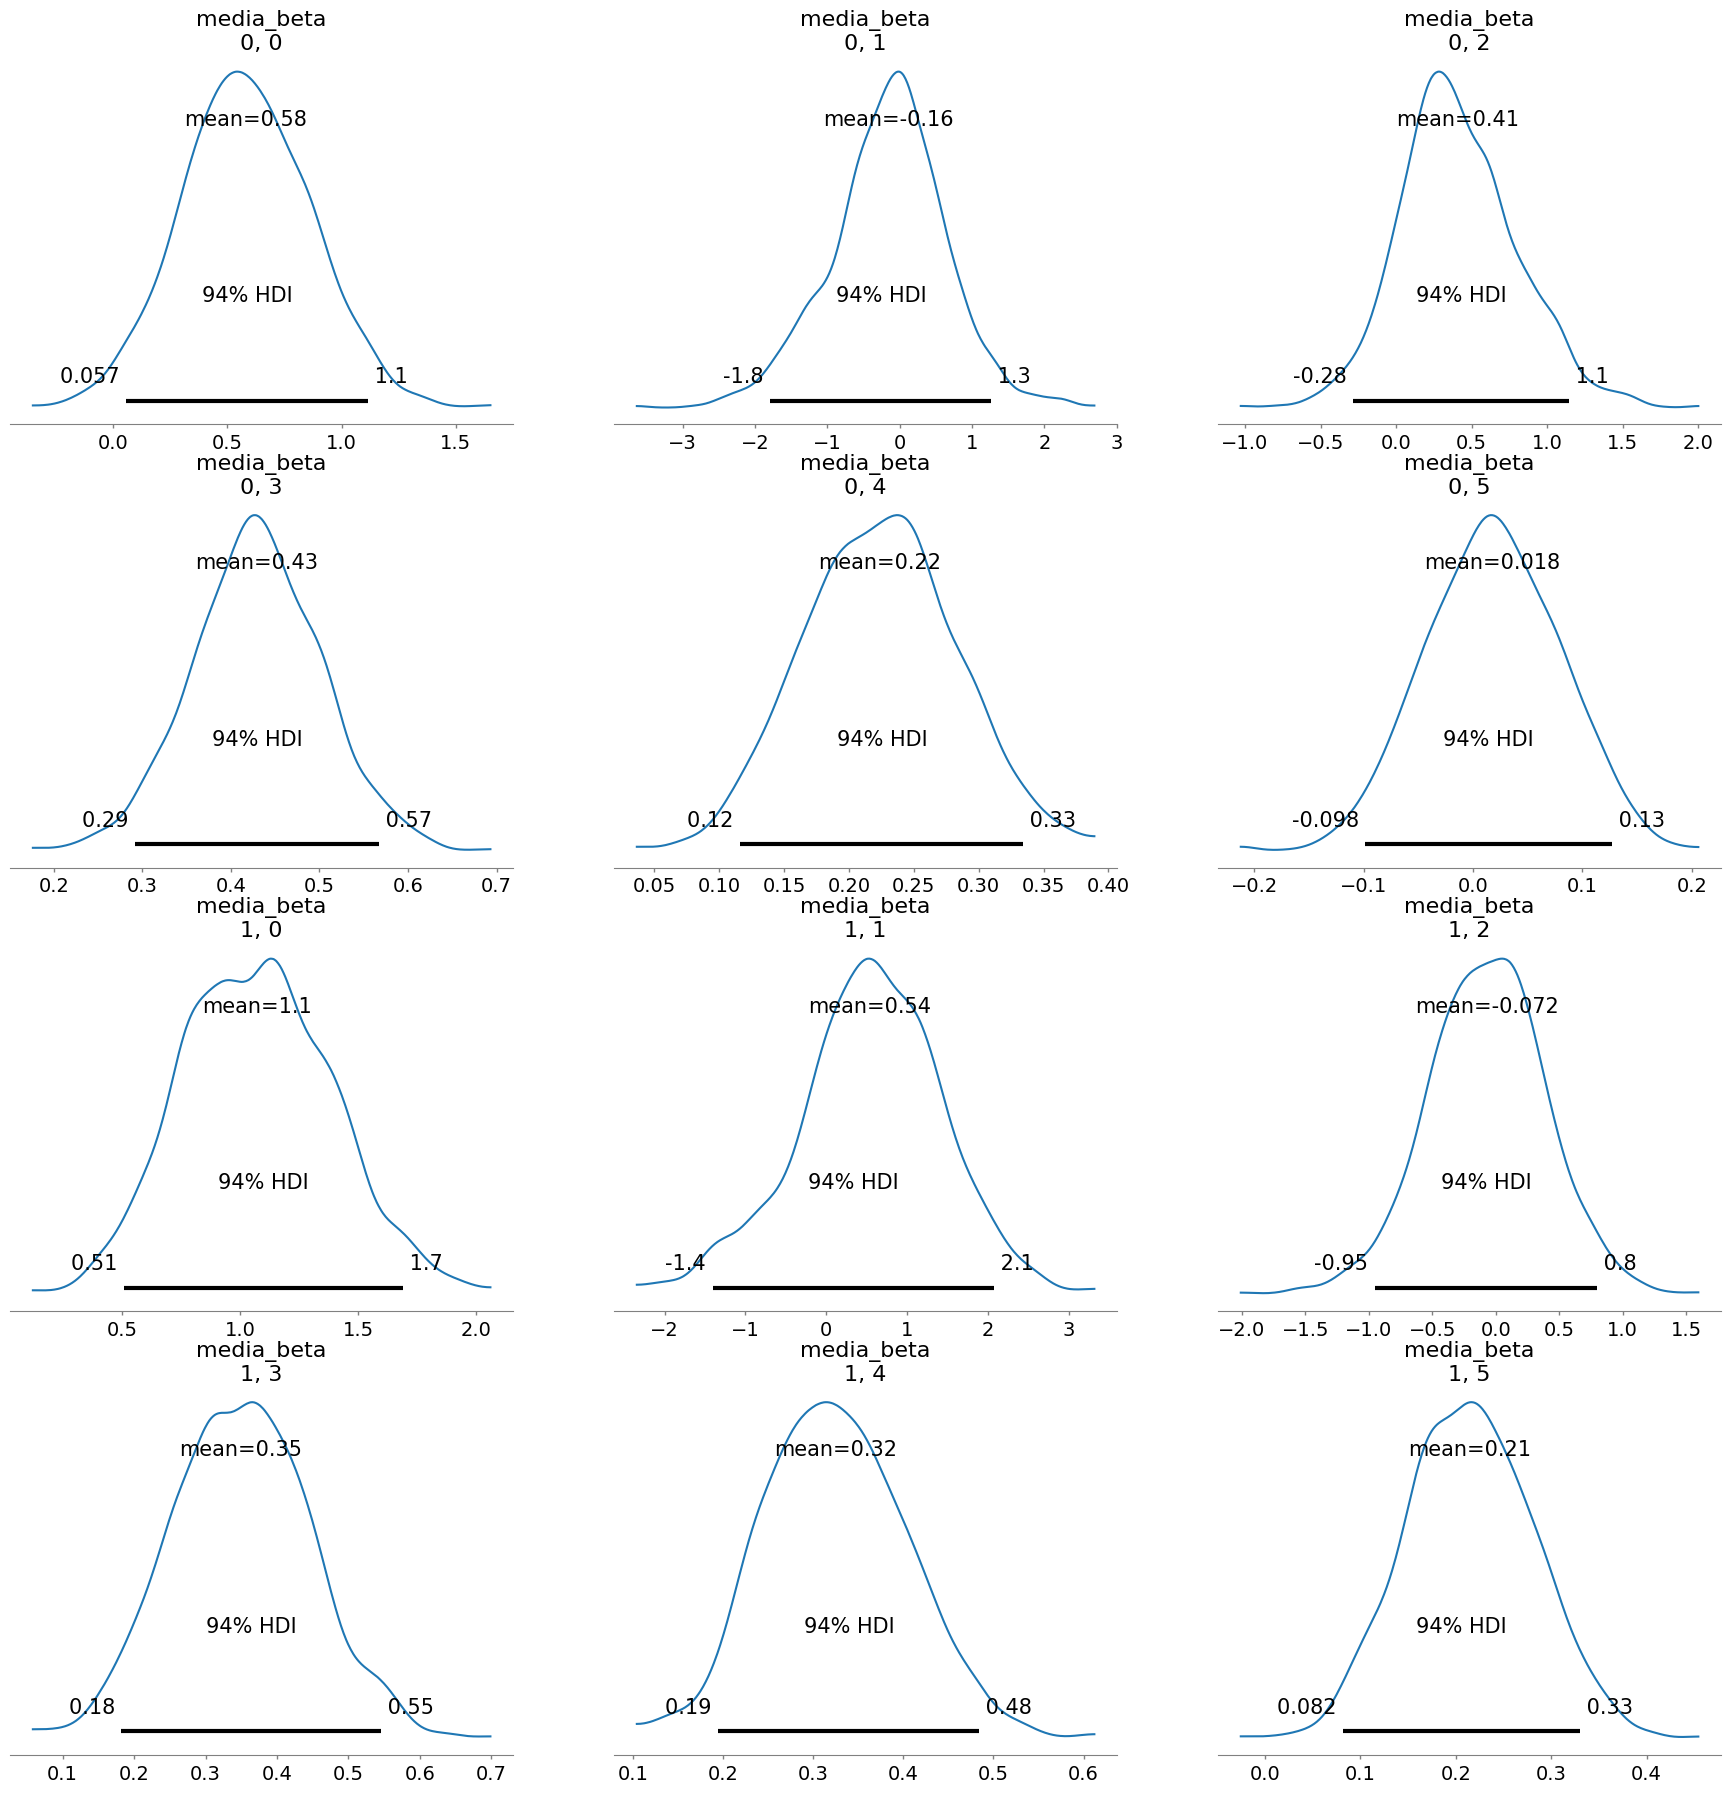

In [355]:
az.plot_posterior(reg_test_1.ToArviZ(),[ "media_beta_one", "media_beta_two"])
az.plot_posterior(reg_test_2.ToArviZ(), "media_beta")

array([<Axes: title={'center': 'intercept\n0'}>,
       <Axes: title={'center': 'intercept\n1'}>], dtype=object)

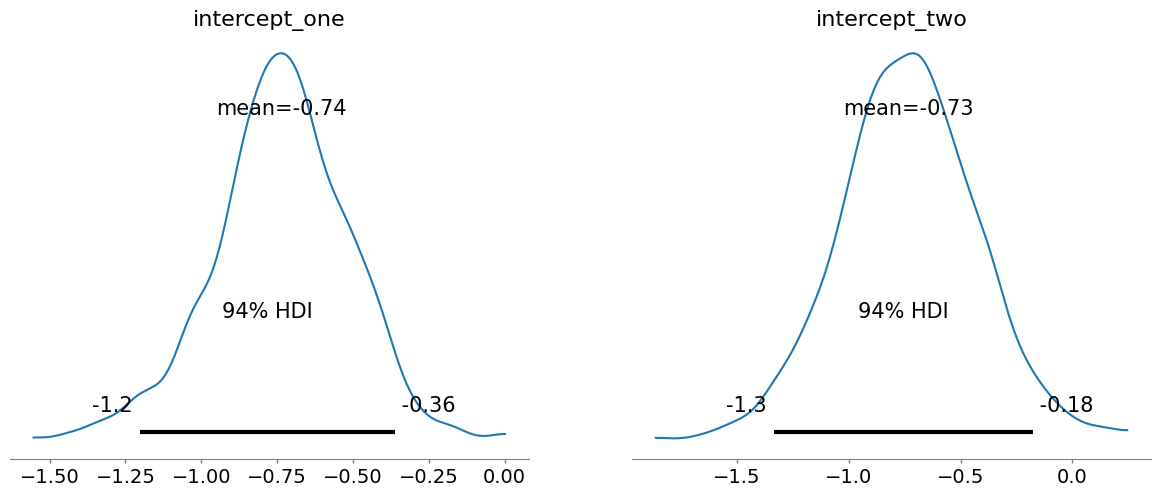

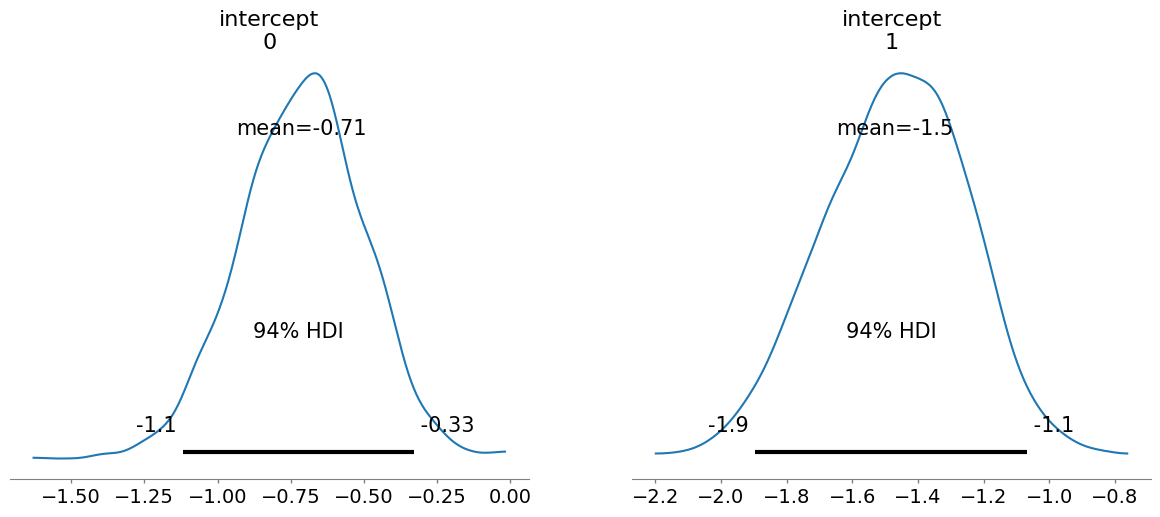

In [325]:
az.plot_posterior(reg_test_1.ToArviZ(), ["intercept_one", "intercept_two"])
az.plot_posterior(reg_test_2.ToArviZ(), "intercept")

### тесты

In [36]:
y = model_data['COMAW_01'].values
Xc = model_data[['tv_fr', 'onl_fr', 'tv_onl']].values
Xn = model_data[['MC2', 'WOM2', 'EX2']].values
Xr = model_data['Noodle_frequent_buyers'].values

reg1 = BayesRegression("1").Fit(media_freq=Xc, non_media=Xn, rg_var=None, y=y)
print(az.waic(reg1.ToArviZ()))

NoRG


sample: 100%|██████████████████████████| 3000/3000 [00:16<00:00, 180.84it/s, 63 steps of size 5.82e-02. acc. prob=0.96]


Computed from 2000 posterior samples and 1200 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -735.20    13.21
p_waic        8.27        -


array([[<Axes: title={'center': 'beta\n0, 0'}>,
        <Axes: title={'center': 'beta\n0, 1'}>,
        <Axes: title={'center': 'beta\n0, 2'}>],
       [<Axes: title={'center': 'beta\n0, 3'}>,
        <Axes: title={'center': 'beta\n0, 4'}>,
        <Axes: title={'center': 'beta\n0, 5'}>]], dtype=object)

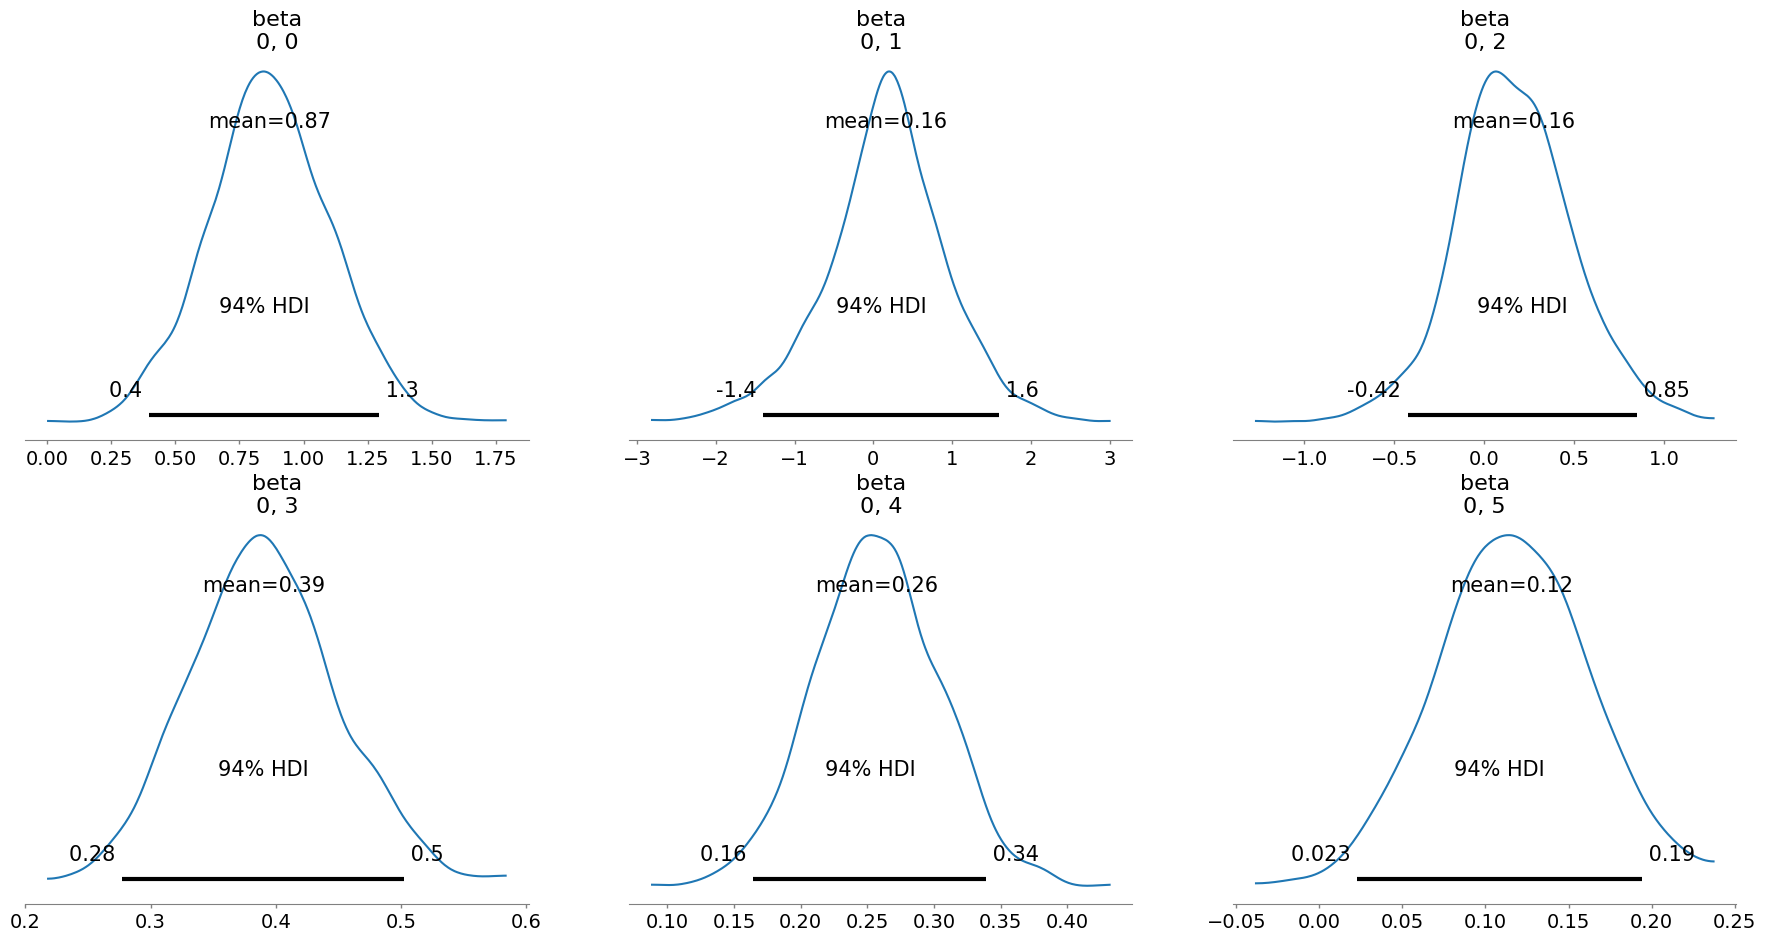

In [43]:
az.plot_posterior(reg1.ToArviZ(), "beta")

sample: 100%|██████████████████████████| 3000/3000 [00:12<00:00, 232.35it/s, 63 steps of size 9.72e-02. acc. prob=0.97]


Computed from 2000 posterior samples and 1200 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -805.30     7.57
p_waic        8.34        -


array([[<Axes: title={'center': 'beta\n0, 0'}>,
        <Axes: title={'center': 'beta\n0, 1'}>,
        <Axes: title={'center': 'beta\n0, 2'}>,
        <Axes: title={'center': 'beta\n0, 3'}>],
       [<Axes: title={'center': 'beta\n1, 0'}>,
        <Axes: title={'center': 'beta\n1, 1'}>,
        <Axes: title={'center': 'beta\n1, 2'}>,
        <Axes: title={'center': 'beta\n1, 3'}>]], dtype=object)

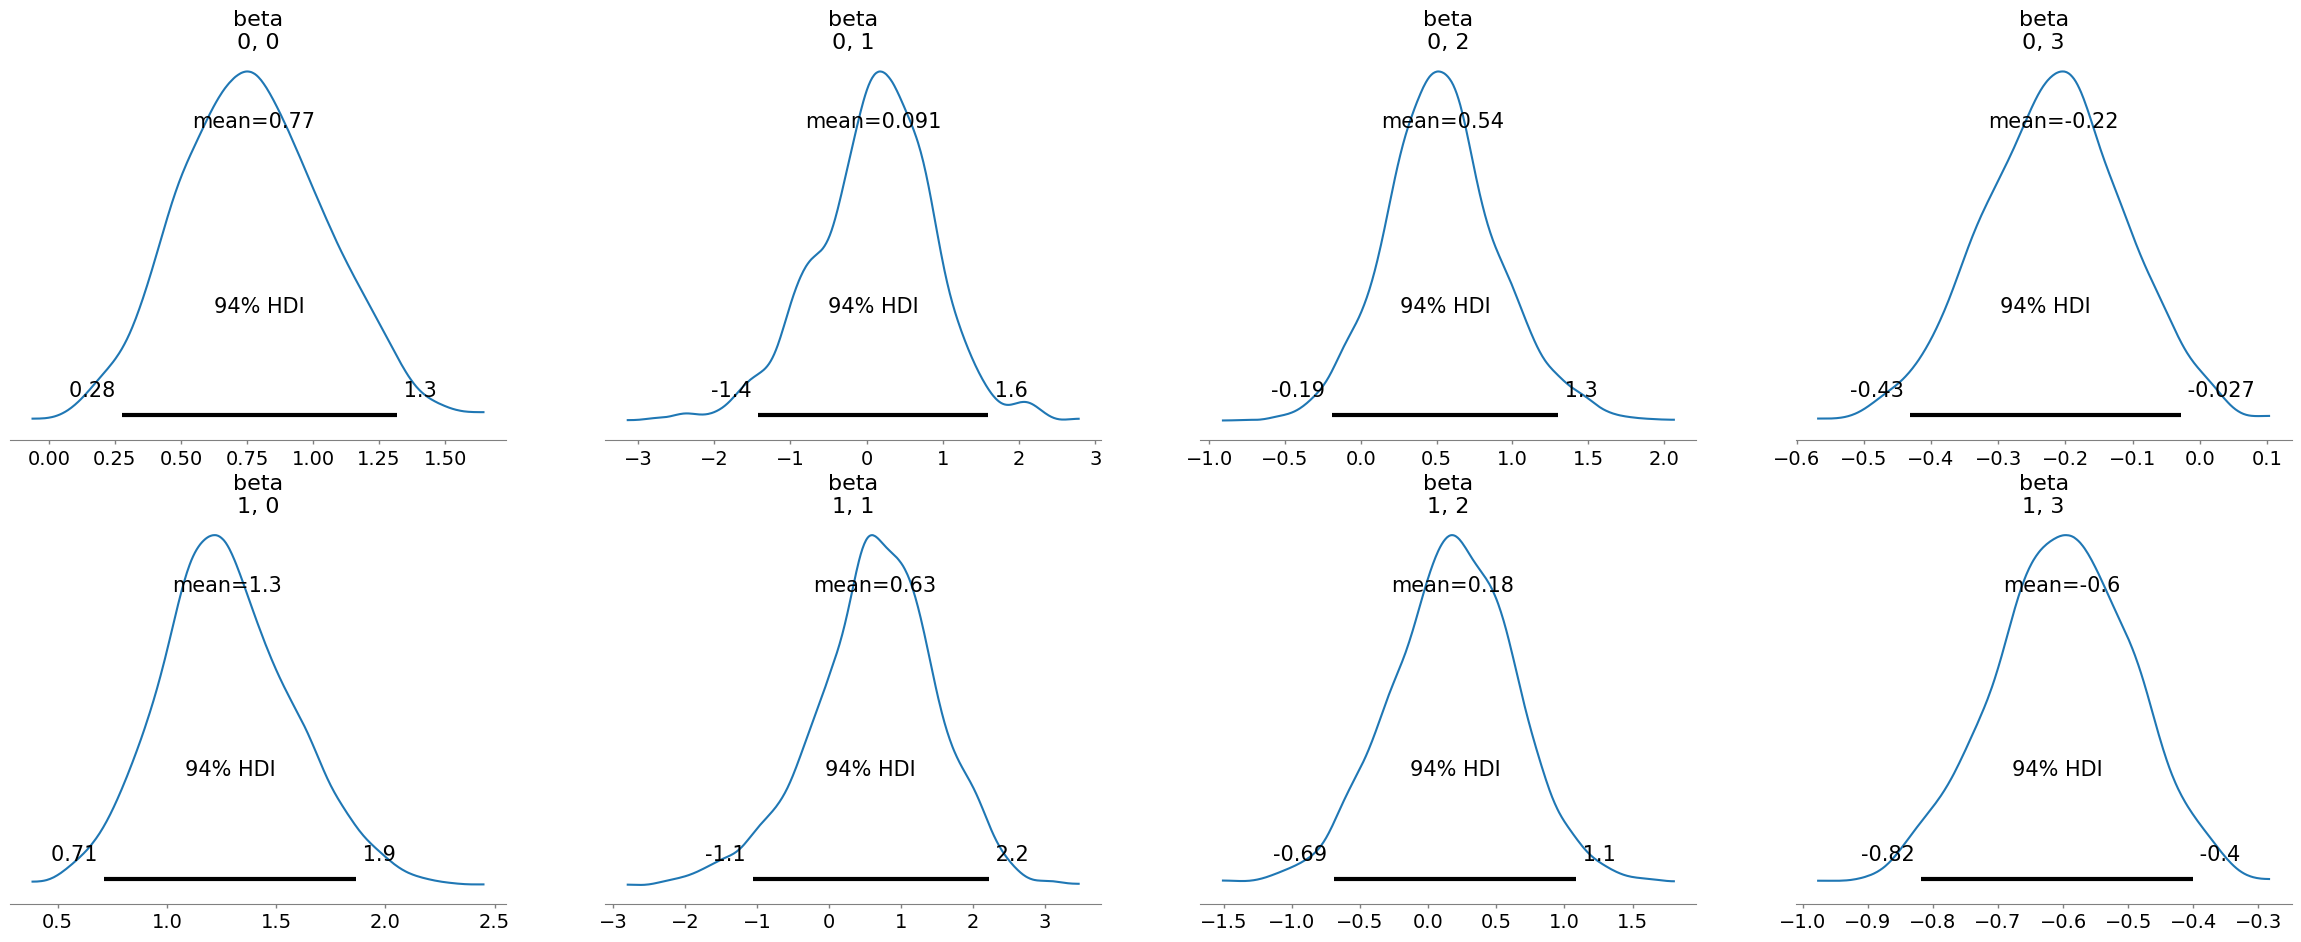

In [77]:
y = model_data['COMAW_01'].values
Xc = model_data[['tv_fr', 'onl_fr', 'tv_onl']].values
Xn = model_data[['MC2', 'WOM2', 'EX2']].values
Xr = model_data['Noodle_frequent_buyers'].values

reg3 = BayesRegression("1").Fit(media_freq=Xc, non_media=None, split_var=Xr, y=y)
print(az.waic(reg3.ToArviZ()))
az.plot_posterior(reg3.ToArviZ(), "beta")

         rank   elpd_waic    p_waic  elpd_diff        weight         se  \
1           0 -735.038241  8.079176   0.000000  1.000000e+00  13.125891   
2           1 -735.135321  8.160486   0.097080  0.000000e+00  13.143996   
RG: nfb     2 -735.200304  8.270304   0.162063  2.220446e-16  13.211124   

              dse  warning scale  
1        0.000000    False   log  
2        0.082124    False   log  
RG: nfb  0.187564    False   log  


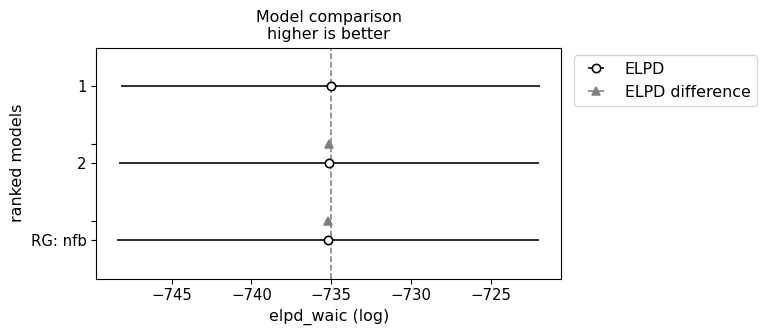

In [60]:
Compare(reg1, reg2, reg3)

# Продолжаем 

sample: 100%|██████████████████████████| 3000/3000 [00:08<00:00, 372.13it/s, 15 steps of size 2.31e-01. acc. prob=0.90]


Computed from 2000 posterior samples and 1200 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -735.48    13.30
p_waic       12.52        -


array([[<Axes: title={'center': 'beta\n0, 0'}>,
        <Axes: title={'center': 'beta\n0, 1'}>,
        <Axes: title={'center': 'beta\n0, 2'}>,
        <Axes: title={'center': 'beta\n0, 3'}>],
       [<Axes: title={'center': 'beta\n0, 4'}>,
        <Axes: title={'center': 'beta\n0, 5'}>,
        <Axes: title={'center': 'beta\n0, 6'}>,
        <Axes: title={'center': 'beta\n1, 0'}>],
       [<Axes: title={'center': 'beta\n1, 1'}>,
        <Axes: title={'center': 'beta\n1, 2'}>,
        <Axes: title={'center': 'beta\n1, 3'}>,
        <Axes: title={'center': 'beta\n1, 4'}>],
       [<Axes: title={'center': 'beta\n1, 5'}>,
        <Axes: title={'center': 'beta\n1, 6'}>, <Axes: >, <Axes: >]],
      dtype=object)

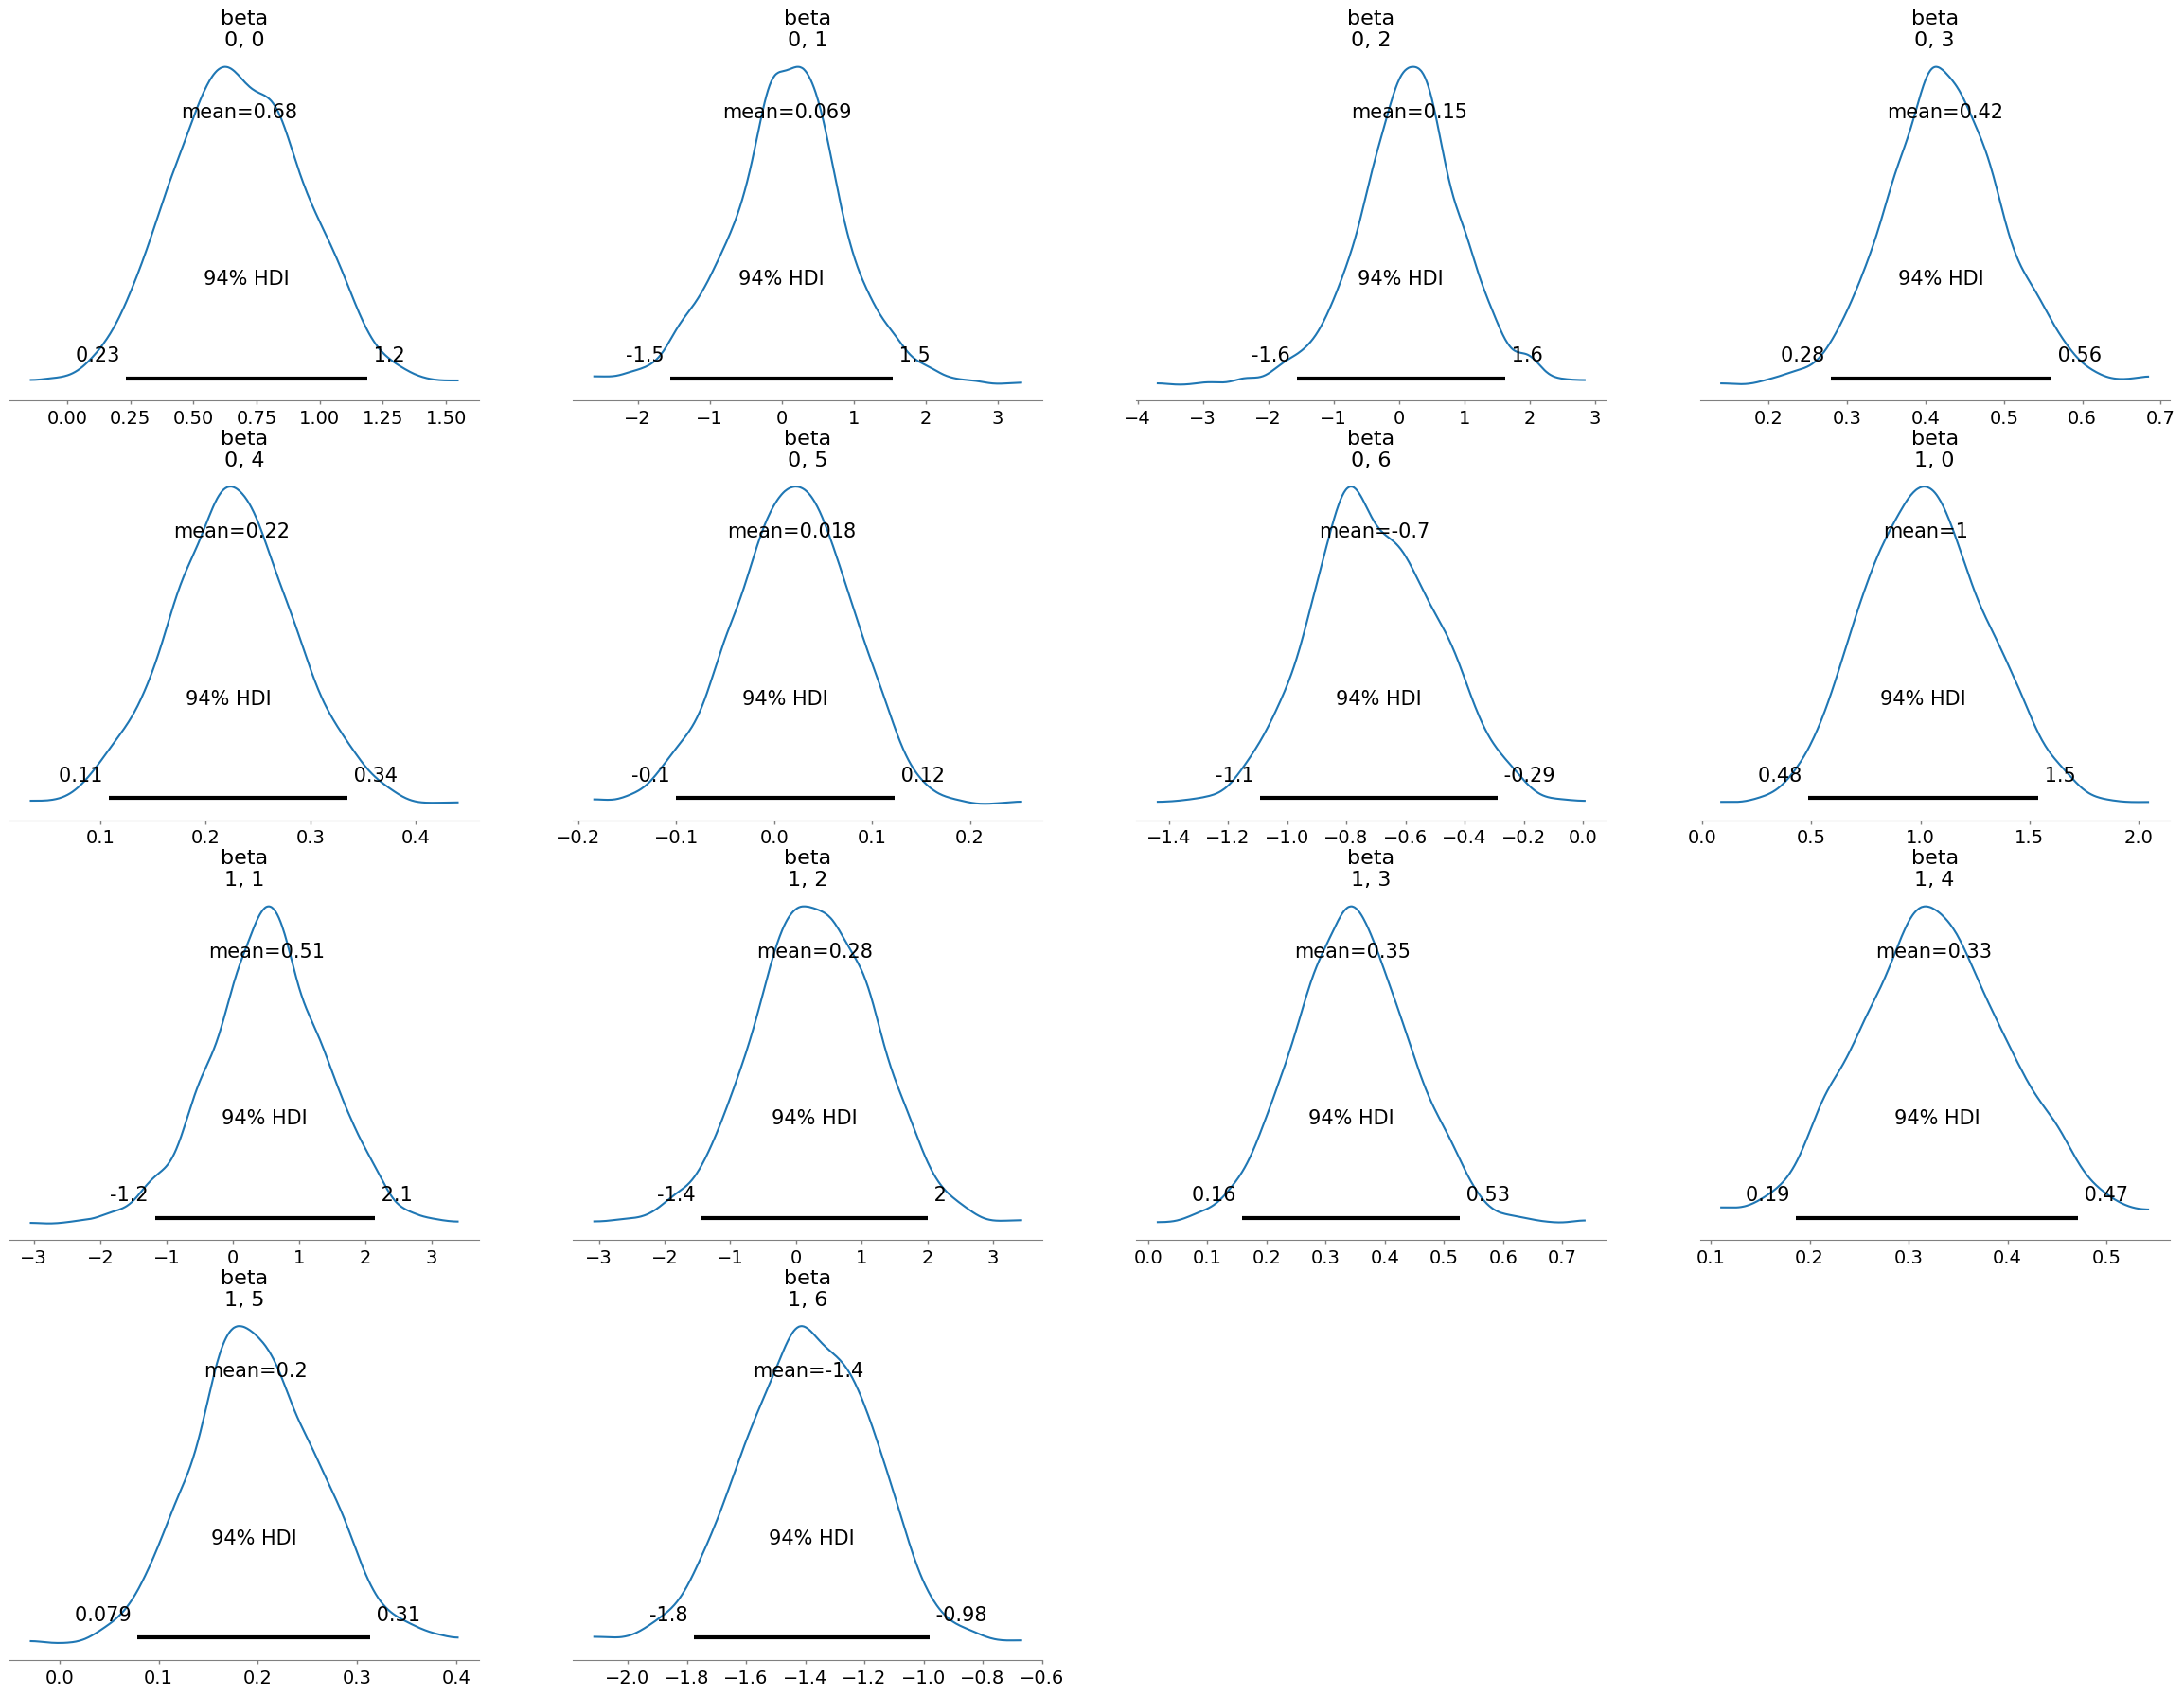

In [96]:
y = model_data['COMAW_01'].values
Xc = model_data[['tv_fr', 'onl_fr', 'bloger']].values
Xn = model_data[['MC2', 'WOM2', 'EX2']].values
Xr = model_data['Noodle_frequent_buyers'].values

reg = BayesRegression("1")
reg.Fit(media=Xc, non_media=Xn, split=Xr, y=y)
print(az.waic(reg.ToArviZ()))
az.plot_posterior(reg.ToArviZ(), "beta")

In [97]:
reg.Contributions().mean(0)

array([0.27021282, 0.16014523, 0.0463764 , 0.00184999, 0.00058279])